# Transmission line circuit

We consider the transmission line model used in  [AKS11]. The RLC circuit of the transmission line is shown below.

<img src="tline.png" alt="Transmission line circuit" style="width: 700px;"/>

Here, $U_{in}$ is the voltage at the sending end, and $U_{out}$ is the voltage at the receiving end.

## Model description

The pre-requisite to understand this model is any standard textbook on electrical circuits. The electrical elements law for resistors (R), inductors (L) and capaicitors (C) are studied, for instance, in [Chapter3, K15].

Let's assume that the network consists of $\eta > 2$ nodes. There are $\eta$ dynamic equations for the capacitor voltages and $\eta$ dynamic equations for the circuit currents. Therefore, the state vector can be represented as

$$
x = [U_1, U_2, \ldots, U_\eta, I_1, I_2, \ldots, I_\eta]^T,
$$
and the state dimension is $2\eta$.

### First node

When writing the equations for the voltages and currents, we should pay attention to the sign choices in the circuit, which are slighyly non-stadard ($U_1$'s positive terminal is at the bottom, etc. as indicated by the arrows).

Let $R_d$ denote the driver resistance's current.

By Kirchhoff's voltage law,

$$
U_{in} = R_d I_1 + LI_1' - U_1,
$$
therefore
$$
\boxed{I_1' = \dfrac{U_{in} + U_1}{L} - \dfrac{R_d}{L}I_1}.
$$

By Kirchhoff's current law, and if $I_{1, C}$ denotes the current through the capacitor $C$, connected to the first node,

$I_1 = I_2 + I_{C, 1}$, and $I_{C, 1} = -CU_1'$, then

$$
\boxed{U_1' = \frac{I_2 - I_1}{C}}.
$$

### Other nodes

Other node's equations are obtained in a similar fashion. For instance, for the second loop one has

$$
-U_1 = RI_2 + LI_2' - U_2 \Rightarrow I_2' = \dfrac{U_2-U_1}{L} - \frac{R}{L}I_2
$$
for the current's equation, and 
$$
I_{2, C} = I_2 - I_3,\Rightarrow U_2' = \frac{I_3 - I_2}{C}.
$$
for the voltage's equation

Generalizing for arbitrary $l = 2, \ldots, \eta - 1$ is trivial and gives:

$$
\boxed{I'_l = \dfrac{U_l - U_{l-1}}{L} - \frac{R}{L}I_l}.
$$

$$
\boxed{U'_l = \dfrac{I_{l+1} - I_l}{C}}.
$$

### Last node

The last node corresponds to the case $l = \eta$

$$
\boxed{I'_\eta = \dfrac{U_\eta - U_{\eta-1}}{L} - \frac{R}{L}I_\eta}.
$$

$$
\boxed{U'_{out} = U'_{out} = - \frac{I_{\eta}}{C}}
$$

### System of differential equations

Recall that that the stateset is $\mathbb{R}^{2\eta}$, where the state variables are $x = [U_1, U_2, \ldots, U_\eta, I_1, I_2, \ldots, I_\eta]^T$. The system can be written as a block-diagonal system of linear ODEs, 

$$
x'(t) = Ax(t) + BU_{in}(t),
$$
using the results in the previous section. There exist useful constructors in `Base.LinearAlgebra` to build matrix with special shape, such as diagonal and band matrices.

In [1]:
using MathematicalSystems, LinearAlgebra, SparseArrays

function tline(;η=3, R=1.00, Rd=10.0, L=1e-10, C=1e-13 * 4.00)
    A₁₁ = zeros(η, η)
    A₁₂ = Bidiagonal(fill(-1/C, η), fill(1/C, η-1), :U)
    A₂₁ = Bidiagonal(fill(1/L, η), fill(-1/L, η-1), :L)
    A₂₂ = Diagonal(vcat(-Rd/L, fill(-R/L, η-1)))
    A  = [A₁₁ A₁₂; A₂₁ A₂₂]
    B = sparse([η+1], [1], 1/L, 2η, 1)
    return A, B
end

tline (generic function with 1 method)

For example, we can visualize the matrices for the case $\eta = 3$ using `ModelingToolkit`:

In [2]:
using ModelingToolkit

@variables R Rd L C
A, B = tline(η=2, R=R, Rd=Rd, L=L, C=C)
Matrix(A)

4×4 Array{Expression,2}:
 Constant(0)  Constant(0)       -1 / C        1 / C
 Constant(0)  Constant(0)  Constant(0)       -1 / C
       1 / L  Constant(0)      -Rd / L  Constant(0)
      -1 / L        1 / L  Constant(0)       -R / L

In [3]:
Matrix(B)

4×1 Array{Operation,2}:
 identity(0)
 identity(0)
       1 / L
 identity(0)

If we now use the default values,

In [4]:
A, B = tline(η=2)
s = LinearControlContinuousSystem(A, B)
Matrix(A)

4×4 Array{Float64,2}:
  0.0     0.0     -2.5e12   2.5e12
  0.0     0.0      0.0     -2.5e12
  1.0e10  0.0     -1.0e11   0.0   
 -1.0e10  1.0e10   0.0     -1.0e10

In [5]:
exp(Matrix(A) * 1e-11)

4×4 Array{Float64,2}:
 -0.239955   0.635306   -5.39454     3.74485 
  0.635306   0.200331   -5.41724    -9.16209 
  0.0215781  0.0216689  -0.0371193   0.418617
 -0.0149794  0.0366484   0.418617   -0.471624

In [6]:
0.002 / 1e-9

2.0e6

In [7]:
Matrix(B)

4×1 Array{Float64,2}:
 0.0   
 0.0   
 1.0e10
 0.0   

Notice that the matrix coefficients are big, and taking the matrix exponential would easily overflow, unless the time-step is of the order of `1e-10`.

Hence, it is convenient to rescale the system. Let $\alpha > 0$ be a scaling factor, and let $\tilde{x}(t) = x(\alpha t)$. By the chain rule, 

$$
\tilde{x}'(t) = \alpha x'(\alpha t) = \alpha A x(\alpha t) + \alpha B U_{in}(\alpha t) = \tilde{A} \tilde{x}(t) + \tilde{B} \tilde{U}_{in}(t),
$$
where $\tilde{A} := \alpha A$ and $\tilde{B} := \alpha B$.

In [8]:
function scale!(s::AbstractContinuousSystem, α=1.0)
    s.A .*= α
    s.B .*= α
    return s
end

scale! (generic function with 2 methods)

In [9]:
scale!(s, 1e-9);

In [10]:
Matrix(s.A)

4×4 Array{Float64,2}:
   0.0   0.0  -2500.0   2500.0
   0.0   0.0      0.0  -2500.0
  10.0   0.0   -100.0      0.0
 -10.0  10.0      0.0    -10.0

In [11]:
Matrix(s.B)

4×1 Array{Float64,2}:
  0.0
  0.0
 10.0
  0.0

In [12]:
exp(Matrix(s.A) * 1e-11)

4×4 Array{Float64,2}:
  1.0       1.25e-18     -2.5e-8        2.5e-8  
  1.25e-18  1.0          -1.04167e-26  -2.5e-8  
  1.0e-10   4.16667e-29   1.0           1.25e-18
 -1.0e-10   1.0e-10       1.25e-18      1.0     

Note that under this transformation, the time horizon has to be transformed as well, through $\tilde{T} = \alpha T$.

## Reachability settings

The transmission line parameters used in this model are displayed in the following table.

|resistance in [Ω] | driver resistance in [Ω] | Inductance in [H]| Capacitance in [F]|
|------|-----|------|-----|
|R = 1.00| Rdriver = 10.0| L = 1e−10 | C = 4e−13|

The steady state is obtained by zeroing the left-hand side of the ODE, obtaining

$$
0 = x' = Ax_\infty + Bu_0 \Rightarrow x_\infty = -A^{-1}B u_0 
$$

The initial set under consideration corresponds to the steady state for input voltages $U_{in, ss} := [-0.2, 0.2]$. Moreover, an uncertainty is added so taht the initial currents are also uncertain. The set of initial states is then

$$
x(0) \in \mathcal{X}_0 := -A^{-1} B  U_{in, ss} \oplus □(0.001),
$$
where $□(ϵ)$ is the infinity-norm ball of center zero and radius $ϵ$.

The time horizon is $T = 0.7s$. For modeling, we consider the scaling parameter $\alpha = 1e-9$.

We study the step response to an input voltage $u_{in}(t)$, constant for $t \in [0, T]$ over the domain $U_{in} = [0.99, 1.01]$.

In [13]:
using LazySets

η = 2 # order
n = 2η # state-space dimension
A, B = tline(η=η)

Uin_ss = Interval(-0.2, 0.2)
□(ϵ) = BallInf(zeros(n), ϵ)
X0 = -inv(Matrix(A))*B*Uin_ss ⊕ □(0.001) # doesn't commute with scaling (!)

Uin = Interval(0.99, 1.01)
s = ConstrainedLinearControlContinuousSystem(A, B, Universe(n), Uin)
α = 1e-9 # scaling factor
scale!(s, α);

T = 0.7 * 1e-11 # time horizon
P = InitialValueProblem(s, X0);

In [14]:
overapproximate(X0, Hyperrectangle).radius

4-element Array{Float64,1}:
 0.201
 0.201
 0.001
 0.001

In [15]:
Matrix(P.s.A)

4×4 Array{Float64,2}:
   0.0   0.0  -2500.0   2500.0
   0.0   0.0      0.0  -2500.0
  10.0   0.0   -100.0      0.0
 -10.0  10.0      0.0    -10.0

In [16]:
Matrix(P.s.B)

4×1 Array{Float64,2}:
  0.0
  0.0
 10.0
  0.0

## Results

In [17]:
using Reachability, Plots
using LazySets: LinearMap

In [18]:
sol = solve(P, Options(:T=>0.7), op=BFFPSV18(:δ=>0.001, :lazy_inputs_interval=> -1));

Computing successors 100%|██████████████████████████████| Time: 0:00:02


In [19]:
Uout = map(x -> -1.0 * project(x.rs.X, [η], LinearMap), sol.Xk)
times = map(x -> Interval(x.rs.t_start, x.rs.t_end), sol.Xk)
Uout_vs_t = [Δt × u for (Δt, u) in zip(times, Uout)];

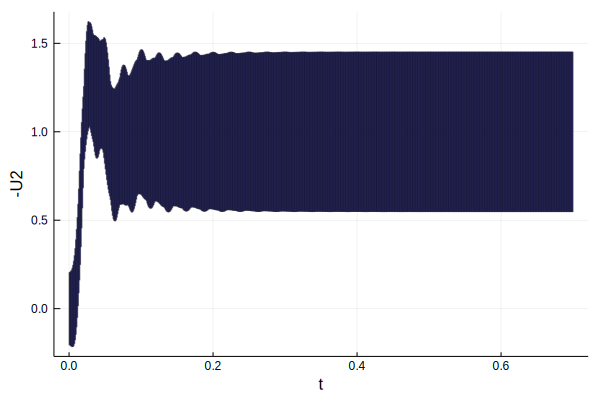

In [20]:
plot(Uout_vs_t[1:1:end], color=:blue, xlab="t", ylab="-U2")

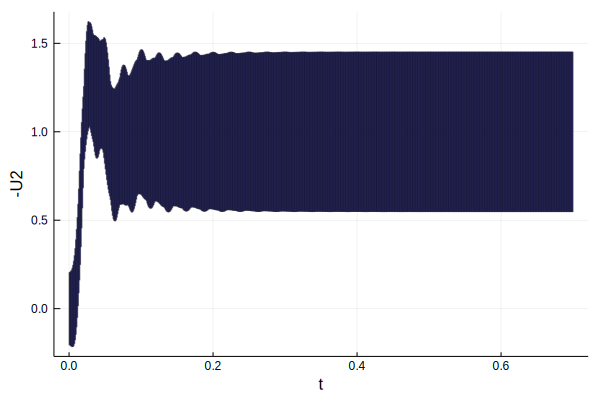

In [21]:
plot(Uout_vs_t[1:1:end], color=:blue, xlab="t", ylab="-U2")

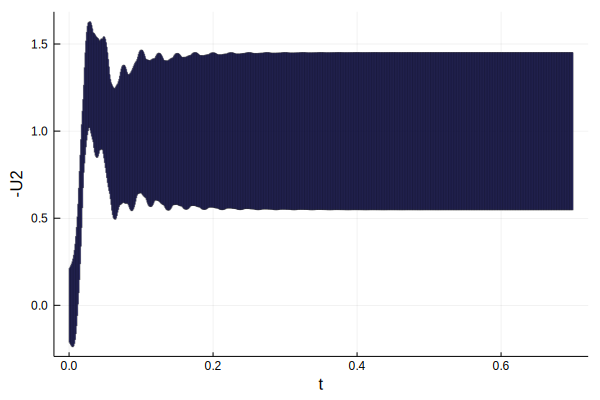

In [22]:
X0 = overapproximate(X0, Hyperrectangle)
P = InitialValueProblem(s, X0);
sol = solve(P, Options(:T=>0.7), op=GLGM06(:δ=>0.001));

Uout = map(x -> -1.0 * project(x.X, [η], LinearMap), sol.Xk)
times = map(x -> Interval(x.t_start, x.t_end), sol.Xk)
Uout_vs_t = [Δt × u for (Δt, u) in zip(times, Uout)];

plot(Uout_vs_t[1:1:end], color=:blue, xlab="t", ylab="-U2")

## Parameter uncertainties

In [23]:
using IntervalMatrices
import IntervalArithmetic
const IA = IntervalArithmetic

IntervalArithmetic

In [40]:
Aint = IntervalMatrix([IA.Interval(x) for x in P.s.A])
Bint = IntervalMatrix([IA.Interval(x) for x in P.s.B])
Uin_int = ConstantInput(LazySets.Interval(0.99, 1.01))
s = ConstrainedLinearControlContinuousSystem(Aint, Bint, nothing, Uin_int) #  TODO: other method
X0 = overapproximate(X0, Hyperrectangle) # for GLGM06
Pint = InitialValueProblem(s, X0);

In [41]:
sol = solve(Pint, Options(:T=>0.7), op=ASB07(:δ=>0.0005, :order_discretization=>10, :max_order=>100));
# :discretization=>"interval_matrix"
Uout = map(x -> -1.0 * project(x.X, [η], LinearMap), sol.Xk)
times = map(x -> Interval(x.t_start, x.t_end), sol.Xk)
Uout_vs_t = [Δt × u for (Δt, u) in zip(times, Uout)];

In [42]:
overapproximate(Uout[20], Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.16436252531561701], [0.3052412464055237])

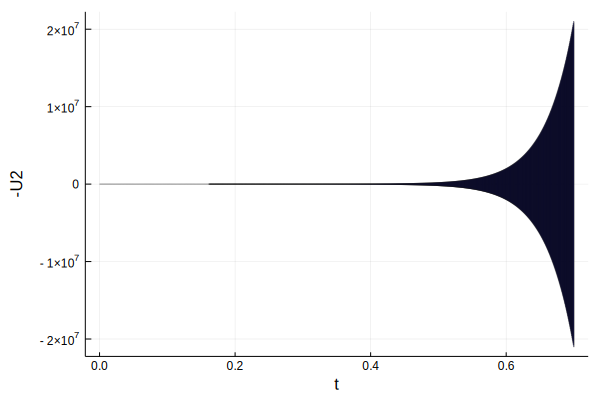

In [43]:
plot(Uout_vs_t[1:1:end], color=:blue, xlab="t", ylab="-U2")

The initial state of the system is determined by the steady state
solution for input voltages Uin = u ∈ [−0.2,0.2] to which an uncertainty is added
so that the initial currents are also uncertain: R(0) = −A
−1bu + (0.001), where
A, b are chosen as the matrix centers of A[z]
, B[z]
, and (0.001) is a box of edge
length 2 · 0.001. At time t = 0, the input is changed to u ∈ [0.99,1.01] so that the
step response of the output voltage Uout = Ul can be verified. For the modeling of
the transmission line, 20 nodes have been used such that the system has 40 state
variables. The reachable set of Uout is presented in Fig. 9 when computing with matrix zonotopes (dark gray) or interval matrices (light gray). It can be observed that
the matrix zonotope computations are much tighter due to the consideration of the
dependency of the R, L, and C values of each 

In [44]:
using IntervalMatrices: expm_overapproximation, expm_underapproximation

In [46]:
Pint.s.A

4×4 IntervalMatrix{Float64,IntervalArithmetic.Interval{Float64},Array{IntervalArithmetic.Interval{Float64},2}}:
     [0, 0]    [0, 0]  [-2500, -2500]    [2500, 2500]
     [0, 0]    [0, 0]          [0, 0]  [-2500, -2500]
   [10, 10]    [0, 0]    [-100, -100]          [0, 0]
 [-10, -10]  [10, 10]          [0, 0]      [-10, -10]

In [47]:
expm_overapproximation(Pint.s.A, 0.002, 15)

4×4 IntervalMatrix{Float64,IntervalArithmetic.Interval{Float64},Array{IntervalArithmetic.Interval{Float64},2}}:
 [-1159.83, 1161.64]  [-1160.69, 1160.78]  …  [-1156.03, 1165.44]
 [-1160.69, 1160.78]  [-1159.78, 1161.69]     [-1165.52, 1155.95]
 [-1160.72, 1160.75]  [-1160.73, 1160.74]     [-1160.69, 1160.78]
 [-1160.75, 1160.72]  [-1160.72, 1160.75]     [-1159.85, 1161.62]

In [49]:
expm_underapproximation(Pint.s.A, 0.002, 15)

4×4 IntervalMatrix{Float64,IntervalArithmetic.Interval{Float64},Array{IntervalArithmetic.Interval{Float64},2}}:
  [0.905496, 0.905497]     …   [4.70961, 4.70962]    
  [0.0484534, 0.0484535]      [-4.78736, -4.78735]   
  [0.017517, 0.0175171]        [0.0453436, 0.0453437]
 [-0.0188385, -0.0188384]      [0.883548, 0.883549]  

In [51]:
exp(mid(Pint.s.A) * 0.002)

4×4 Array{Float64,2}:
  0.905497   0.0484535    -4.37927     4.70961  
  0.0484535  0.951152     -0.0777469  -4.78736  
  0.0175171  0.000310987   0.77567     0.0453436
 -0.0188385  0.0191494     0.0453436   0.883549 

In [34]:
A = [1.0 2.0; 3.0 4.0] * 100
Aint = IntervalMatrix([IA.Interval(x) for x in A])

2×2 IntervalMatrix{Float64,IntervalArithmetic.Interval{Float64},Array{IntervalArithmetic.Interval{Float64},2}}:
 [100, 100]  [200, 200]
 [300, 300]  [400, 400]

In [35]:
expm_overapproximation(Aint, 0.01, 10)

2×2 IntervalMatrix{Float64,IntervalArithmetic.Interval{Float64},Array{IntervalArithmetic.Interval{Float64},2}}:
 [-68.0392, 169.735]  [-45.7845, 191.99] 
  [-9.2332, 228.541]   [41.6145, 279.389]

In [36]:
exp(A * 0.01)

2×2 Array{Float64,2}:
  51.969   74.7366
 112.105  164.074 

In [53]:
κ(1 .. 2, 1.0)

1.5

In [54]:
using LinearAlgebra: checksquare

@inline function κ(aii, t)
    if -1/t ∈ aii
        return -1/2
    else
        return min(inf(aii)*t+inf(aii)^2*t^2/2, sup(aii)*t+sup(aii)^2*t^2/2)
    end
end

function quadratic_expansion_old(A::IntervalMatrix, t)
    #n = checksquare(A)

    W = similar(A)

    for i in 1:n
        for j in 1:n
            if i ≠ j
                W[i, j] = A[i, j] * (t + (A[i, i] + A[j, j])*(t^2/2.))
                S = 0
                for k in 1:n
                    if k ≠ i && k ≠ j
                        S = S + A[i, k] * A[k, j]
                    end
                end
                W[i, j] = W[i, j] + S * (t^2/2.)
            else
                u = inf(A[i, i])* t + inf(A[i, i])^2 * t^2/2
                v = sup(A[i, i]) * t + sup(A[i, i])^2 * t^2/2
                W[i, i] = IA.Interval(κ(A[i, i], t), max(u, v))
                S = 0
                for k in 1:n
                    if k ≠ i
                        S = S + A[i, k] * A[k, i]
                    end
                end
                W[i, i] = W[i, i] + S * (t^2/2.)
            end
        end
    end
    return W
end

quadratic_expansion_old (generic function with 1 method)

In [58]:
function expm_overapproximation_old(A::IntervalMatrix{T}, t, p) where {T}
    n = size(A, 1)
    Id = IntervalMatrix(fill(zero(T)±zero(T), (n , n)))
    for i in 1:n
        Id[i, i] = one(T)±zero(T)
    end
    Γ = IntervalMatrix(fill(zero(T)±one(T), (n , n)))
    nA = norm(A, Inf)
    c = nA * t / (p + 2)
    @assert c < 1
    E = Γ * ((nA*t)^(p+1) * (1/factorial(p + 1) * 1/(1-c)))

    S = IntervalMatrix(fill(zero(T)±zero(T), (n , n)))
    Ai = A * A * A
    for i in 3:p
        S = S + Ai * (t^i/factorial(i))
        Ai = Ai * A
    end
    W = quadratic_expansion(A, t)
    return Id + W + S + E
end

expm_overapproximation_old (generic function with 2 methods)

In [60]:
expm_overapproximation_old(Pint.s.A, 0.002, 15)

4×4 IntervalMatrix{Float64,IntervalArithmetic.Interval{Float64},Array{IntervalArithmetic.Interval{Float64},2}}:
  [0.895165, 0.915829]      …   [4.69928, 4.71995]    
  [0.0381218, 0.0587852]       [-4.7977, -4.77702]    
  [0.00718545, 0.0278487]       [0.0350119, 0.0556753]
 [-0.0291701, -0.00850683]      [0.873217, 0.893881]  

## References

[AKS11] Althoff, Matthias, Bruce H. Krogh, and Olaf Stursberg. [Analyzing reachability of linear dynamic systems with parametric uncertainties.](http://www.i6.in.tum.de/Main/Publications/Althoff2011b.pdf). Modeling, Design, and Simulation of Systems with Uncertainties. Springer, Berlin, Heidelberg, 2011. 69-94.

[K15] Kluever, Craig A. [Dynamic systems: modeling, simulation, and control.](https://www.wiley.com/en-us/Dynamic+Systems%3A+Modeling%2C+Simulation%2C+and+Control-p-9781118289457). John Wiley & Sons, 2015.

[GLG08] Girard, Antoine, and Colas Le Guernic. [Efficient reachability analysis for linear systems using support functions.]() IFAC Proceedings Volumes 41.2 (2008): 8966-8971.